In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
#from lmfit import Parameter, Parameters, Minimizer
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

from itertools import product

from mixcoatl.gridFitTask import GridFitTask, DistortedGrid
from mixcoatl.sourcegrid import coordinate_distances

camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

## Testing Full Fitting

In [27]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6865D_dither/catalogs/*.cat')
infile = infiles[0]
print(infile)

## Obtain initial guess for grid center
basename = os.path.basename(infile)
projector_y = float(basename.split('_')[-1][:-5]) # camera x/y coords
projector_x = float(basename.split('_')[-2][:-1])

ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(projector_y, projector_x)

dx0 = -30.
dy0 = -70.

x0_guess = 2*509*4. - ccd_x + dx0
y0_guess = ccd_y + dy0
print(y0_guess, x0_guess)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6865D_dither/catalogs/MC_C_20191031_000144_R02_S02_20.0s_-294.1x_38.5y.cat
2167.5 2323.5


In [30]:
gridfit_task = GridFitTask()
gridfit_task.config.brute_search = False
gridfit_task.config.outfile = 'test_distorted_grid.cat'

grid, result = gridfit_task.run(infile, (y0_guess, x0_guess),
                                optics_grid_file='optics_distorted_grid.fits')

2165.076643230659 2324.4466095577473
(2421,)


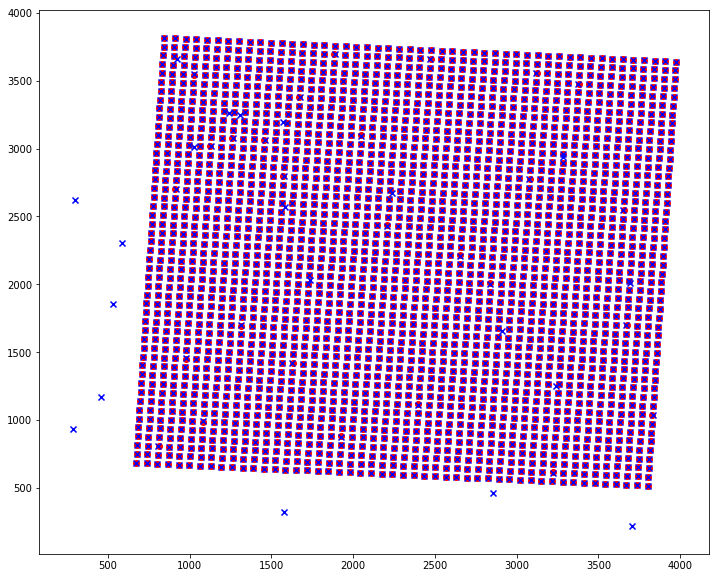

In [31]:
gY, gX = grid.get_source_centroids(distorted=True)
print(grid.y0, grid.x0)

src = fits.open(infile)
srcY = src[1].data['base_SdssShape_Y']
srcX = src[1].data['base_SdssShape_X']
print(srcY.shape)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.scatter(gX, gY, color='red')
ax.scatter(srcX, srcY, color='blue', marker='x')

## Test Partial Fit

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_20.8_004/R12_S11_source_catalog.cat


/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


1967.2565344704549 -72.19399960158773 -0.0536878337938898


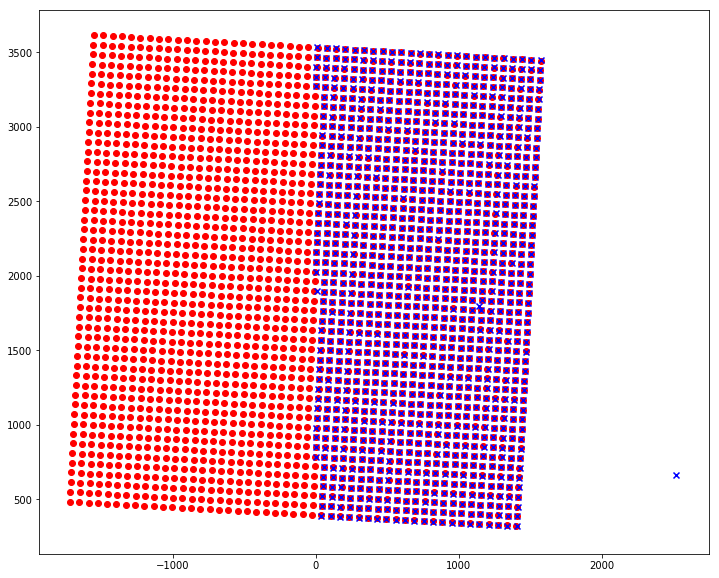

In [8]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_20.8_004/*.cat')
infile0 = infiles[0]
print(infile0)

src0 = fits.getdata(infile0)
all_src0Y = src0['base_SdssCentroid_Y']
all_src0X = src0['base_SdssCentroid_X']

## Curate data here (remove bad shapes, fluxes, etc.)
all_src0W = np.sqrt(np.square(src0['base_SdssShape_XX']) + \
                       np.square(src0['base_SdssShape_YY']))
mask = (all_src0W > 5.)

src0Y = all_src0Y[mask]
src0X = all_src0X[mask]

gridfit_task = GridFitTask()
gridfit_task.config.brute_search = False
gridfit_task.config.vary_theta = True
gridfit_task.config.outfile = 'test_gridspacing_distorted_grid.fits'

grid0, result0 = gridfit_task.run(infile0, (1980., -80), optics_grid_file='optics_distorted_grid.fits')
print(grid0.y0, grid0.x0, grid0.theta)
g0Y, g0X = grid0.get_source_centroids(distorted=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(g0X, g0Y, color='red')
ax.scatter(src0X, src0Y, color='blue', marker='x')

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6871D_spacing/spacing_-127.0_20.8_004/R12_S12_source_catalog.cat
1962.6861529051143 4152.370837167112 -0.054628141529680374


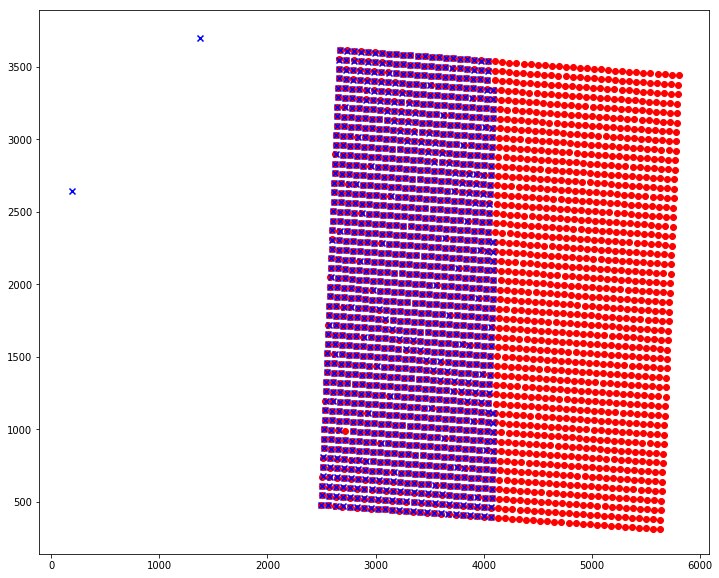

In [9]:
infile1 = infiles[1]
print(infile1)

src1 = fits.getdata(infile1)
all_src1Y = src1['base_SdssCentroid_Y']
all_src1X = src1['base_SdssCentroid_X']

## Curate data here (remove bad shapes, fluxes, etc.)
all_src1W = np.sqrt(np.square(src1['base_SdssShape_XX']) + \
                       np.square(src1['base_SdssShape_YY']))
mask = (all_src1W > 5.)

src1Y = all_src1Y[mask]
src1X = all_src1X[mask]

gridfit_task = GridFitTask()
gridfit_task.config.brute_search = False
gridfit_task.config.vary_theta = True
gridfit_task.config.outfile = 'test_gridspacing_distorted_grid.fits'

grid1, result1 = gridfit_task.run(infile1, (1980., 4160), optics_grid_file='optics_distorted_grid.fits')
print(grid1.y0, grid1.x0, grid1.theta)
g1Y, g1X = grid1.get_source_centroids(distorted=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(g1X, g1Y, color='red')
ax.scatter(src1X, src1Y, color='blue', marker='x')

(0, 4000)

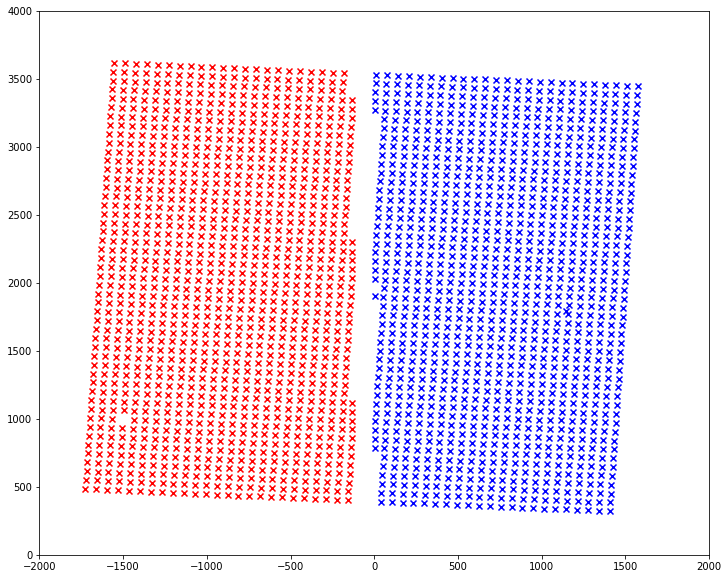

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(src0X, src0Y, color='blue', marker='x')
ax.scatter(src1X-grid1.x0+grid0.x0, src1Y-grid1.y0+grid0.y0, color='red', marker='x')
ax.set_xlim(-2000, 2000)
ax.set_ylim(0, 4000)

## Make Optic Distortions

In [2]:
old_infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6865D_dither/raw_data/*.fits')

xstep = np.zeros(len(old_infiles))
ystep = np.zeros(len(old_infiles))
theta = np.zeros(len(old_infiles))

for i, infile in enumerate(old_infiles):

    with fits.open(infile) as hdul:
        ## Read input file
        hdul = fits.open(infile)
        grid_dy = hdul[1].header['DY']
        grid_dx = hdul[1].header['DX']
        grid_theta = hdul[1].header['THETA']
        
        xstep[i] = grid_dx
        ystep[i] = grid_dy
        theta[i] = grid_theta
        
mean_xstep = np.mean(xstep)
mean_ystep = np.mean(ystep)
mean_theta = np.mean(theta)

print(mean_xstep, mean_ystep, mean_theta)

65.31093343064991 65.32370850598572 -0.054969066855609


In [4]:
## Get old optic distortion file
hdul = fits.open('corrected_grid_pt_average_displacement.fits')

dx = hdul[0].data[:, 0]
dy = hdul[0].data[:, 1]

centroid_shifts = (dy, dx)

optics_grid = DistortedGrid(mean_ystep, mean_xstep, mean_theta, 0, 0, 49, 49)
optics_grid.add_centroid_shifts((dy, dx))
#optics_grid.write_fits('optics_distorted_grid.fits', overwrite=True)

[-0.03239051 -0.02482529 -0.02517442 ... -0.03732271 -0.03932986
 -0.04220486]


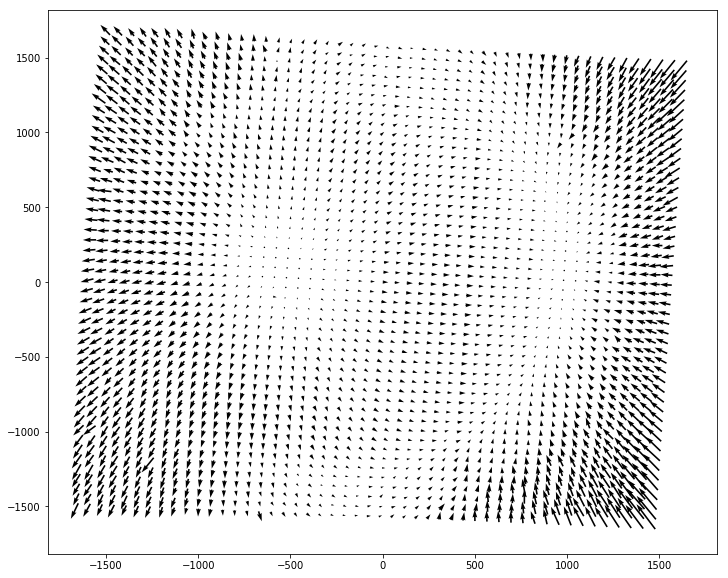

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gY, gX = optics_grid.get_source_centroids(distorted=False)
gDY, gDX = optics_grid.get_centroid_shifts()

ax.quiver(gX, gY, gDX, gDY)
print(optics_grid.norm_dy)

[-0.03239051 -0.02482529 -0.02517442 ... -0.03732271 -0.03932986
 -0.04220486]


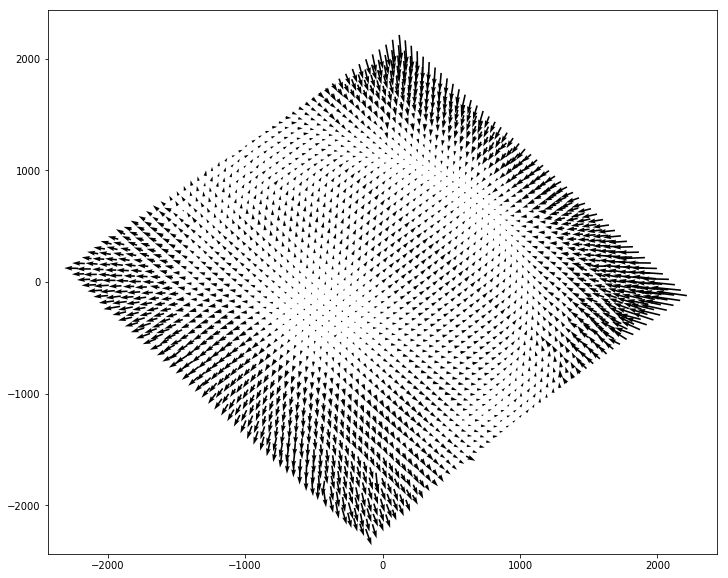

In [34]:
## Rotate by 45 degrees
optics_grid.theta += np.pi/4

gY, gX = optics_grid.get_source_centroids(distorted=False)
gDY, gDX = optics_grid.get_centroid_shifts()
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.quiver(gX, gY, gDX, gDY)
print(optics_grid.norm_dy)

## Adding Matched Catalog

In [11]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/*.cat')
infile = infiles[0]
print(infile)

src = fits.open(infile)

/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/MC_C_20191029_005396_R22_S11_15.0s_0.0x_0.0y.cat


In [21]:
tablehdu = src[1].data
print(src[1].columns)
print(tablehdu)

ColDefs(
    name = 'flags'; format = '97X'
    name = 'id'; format = '1K'
    name = 'coord_ra'; format = '1D'; unit = 'rad'
    name = 'coord_dec'; format = '1D'; unit = 'rad'
    name = 'parent'; format = '1K'
    name = 'base_NaiveCentroid_x'; format = '1D'; unit = 'pixel'
    name = 'base_NaiveCentroid_y'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_x'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_y'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_xErr'; format = '1E'; unit = 'pixel'
    name = 'base_SdssCentroid_yErr'; format = '1E'; unit = 'pixel'
    name = 'base_Blendedness_old'; format = '1D'
    name = 'base_Blendedness_raw'; format = '1D'
    name = 'base_Blendedness_raw_child_instFlux'; format = '1D'; unit = 'count'
    name = 'base_Blendedness_raw_parent_instFlux'; format = '1D'; unit = 'count'
    name = 'base_Blendedness_abs'; format = '1D'
    name = 'base_Blendedness_abs_child_instFlux'; format = '1D'; unit = 'count'
    nam

# Archive